## Import

In [37]:
# to manage paths
import os
# to process images
import cv2
# to read MATLAB file
from scipy import io
# for array operations
import numpy as np
# for final dataframe outputs
import pandas as pd
# to display images
import matplotlib.pyplot as plt
# to display image legends
import matplotlib as mpl
# to process tensors
import tensorflow as tf

In [38]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


### Have a Look at the downloaded contents

In [39]:
!ls -p clothing-co-parsing

LICENSE            annotations/       label_list.mat     show_image_anno.m
README.md          example.jpg        photos/            show_pixel_anno.m


### `photos/` directory and `annotations/` directory are the images and segmentations collections respectively.

# Read Images, Segmentations and Labels

### There are 1000 images of people fashion and clothing - and corresponding 1000 segmentation mask images. The image files are in JPG format and masks are in MATLAB format. The files do not have consistency in size (variable height). However, image and mask pairs do have identical sizes. We read the files and write them into tensors for further processing.

### 1. Read Images

In [40]:
# a list to store image tensors
images = []
# read 1000 images
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    # use OpenCV for lossless reading
    img = cv2.imread(url, 1)
    # convert BGR image into RGB image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # convert into a tensor
    img = tf.convert_to_tensor(img)
    # resize the image by either cropping or padding with zeros
    img = tf.image.resize_with_crop_or_pad(img,825,550)
    # add to the list
    images.append(img)

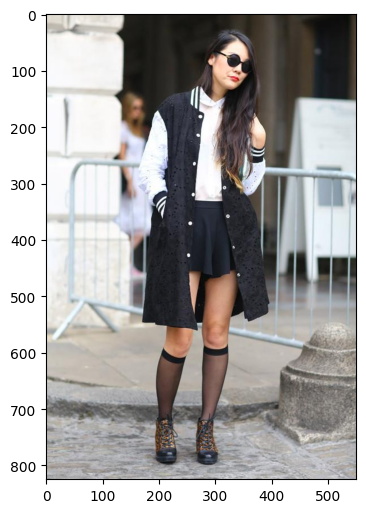

In [41]:
# sample an image and visualize it
plt.figure(figsize=(4,7))
example_image = images[0]
plt.imshow(example_image)
plt.show()

### 2. Segmentations

In [42]:
# a list to collect mask tensors
segmentations = []
# read 1000 files
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    # read MATLAB file as image
    file = io.loadmat(url)
    # convert into a tensor
    mask = tf.convert_to_tensor(file['groundtruth'])
    # resize expects 3D image, but we got 2D grayscale image
    # so expand dimensions
    mask = tf.expand_dims(mask,-1)
    # resize by either cropping excess or padding with zeros
    mask = tf.image.resize_with_crop_or_pad(mask,825,550)
    # append the mask image to the list
    segmentations.append(mask)

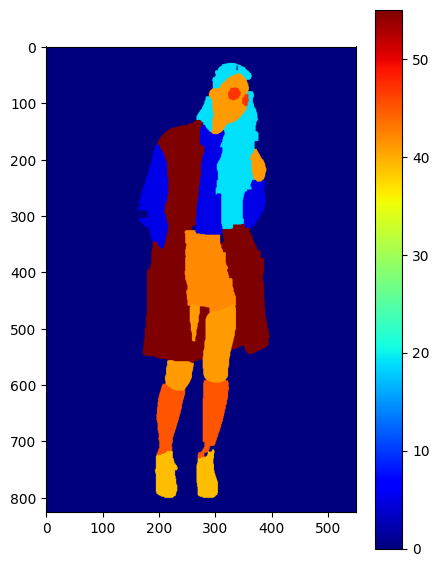

In [43]:
# sample a mask and visualize it
example_seg = segmentations[0]
plt.figure(figsize=(5,7))
plt.imshow(example_seg, cmap='jet')
plt.colorbar()
plt.show()

In [44]:
# what are the unique pixel values?
np.unique(example_seg)

array([ 0,  5, 19, 39, 41, 42, 45, 47, 55], dtype=uint8)

### 3. Read Labels

In [45]:
label_url = './clothing-co-parsing/label_list'
# read the labels list MATLAB file
label_file = io.loadmat(label_url)['label_list']
# what is its shape?
label_file.shape

(1, 59)

In [46]:
# remove unnecessary dimension
label_file = np.squeeze(label_file)
label_file.shape

(59,)

In [47]:
# view the file
label_file

array([array(['null'], dtype='<U4'), array(['accessories'], dtype='<U11'),
       array(['bag'], dtype='<U3'), array(['belt'], dtype='<U4'),
       array(['blazer'], dtype='<U6'), array(['blouse'], dtype='<U6'),
       array(['bodysuit'], dtype='<U8'), array(['boots'], dtype='<U5'),
       array(['bra'], dtype='<U3'), array(['bracelet'], dtype='<U8'),
       array(['cape'], dtype='<U4'), array(['cardigan'], dtype='<U8'),
       array(['clogs'], dtype='<U5'), array(['coat'], dtype='<U4'),
       array(['dress'], dtype='<U5'), array(['earrings'], dtype='<U8'),
       array(['flats'], dtype='<U5'), array(['glasses'], dtype='<U7'),
       array(['gloves'], dtype='<U6'), array(['hair'], dtype='<U4'),
       array(['hat'], dtype='<U3'), array(['heels'], dtype='<U5'),
       array(['hoodie'], dtype='<U6'), array(['intimate'], dtype='<U8'),
       array(['jacket'], dtype='<U6'), array(['jeans'], dtype='<U5'),
       array(['jumper'], dtype='<U6'), array(['leggings'], dtype='<U8'),
       array

### Each label is an array. Extract the label strings alone.

In [48]:
labels = [label[0].astype(str) for label in label_file]
labels

[np.str_('null'),
 np.str_('accessories'),
 np.str_('bag'),
 np.str_('belt'),
 np.str_('blazer'),
 np.str_('blouse'),
 np.str_('bodysuit'),
 np.str_('boots'),
 np.str_('bra'),
 np.str_('bracelet'),
 np.str_('cape'),
 np.str_('cardigan'),
 np.str_('clogs'),
 np.str_('coat'),
 np.str_('dress'),
 np.str_('earrings'),
 np.str_('flats'),
 np.str_('glasses'),
 np.str_('gloves'),
 np.str_('hair'),
 np.str_('hat'),
 np.str_('heels'),
 np.str_('hoodie'),
 np.str_('intimate'),
 np.str_('jacket'),
 np.str_('jeans'),
 np.str_('jumper'),
 np.str_('leggings'),
 np.str_('loafers'),
 np.str_('necklace'),
 np.str_('panties'),
 np.str_('pants'),
 np.str_('pumps'),
 np.str_('purse'),
 np.str_('ring'),
 np.str_('romper'),
 np.str_('sandals'),
 np.str_('scarf'),
 np.str_('shirt'),
 np.str_('shoes'),
 np.str_('shorts'),
 np.str_('skin'),
 np.str_('skirt'),
 np.str_('sneakers'),
 np.str_('socks'),
 np.str_('stockings'),
 np.str_('suit'),
 np.str_('sunglasses'),
 np.str_('sweater'),
 np.str_('sweatshirt'),
 n

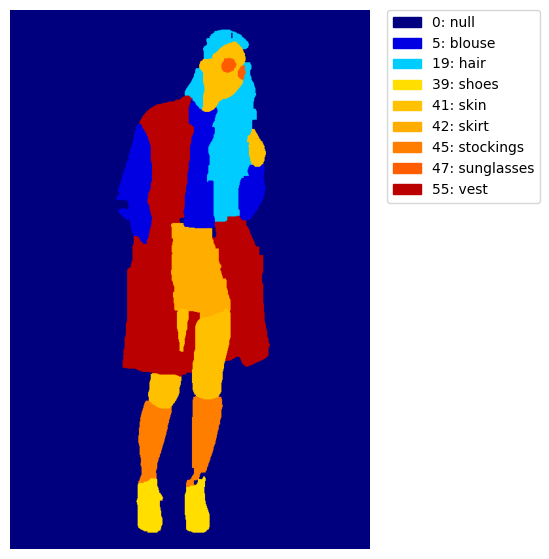

In [49]:
# sample a mask and show the class labels as legends
plt.figure(figsize=(7,7))
example_seg = segmentations[0]
# obtain unique values (the class numbers)
annotations = np.unique(example_seg.numpy().ravel())
# read the names
names = [labels[a] for a in annotations]
# the values range from 0 to 58, hence normalize for homogeneity
NORM = mpl.colors.Normalize(vmin=0, vmax=58)
# visulaize the image
plt.imshow(example_seg, cmap='jet', norm=NORM)
plt.axis('off')
# prepare patches for legends
PATCHES = [mpl.patches.Patch(color=mpl.cm.jet(NORM(a)), label=f'{a}: {names[i]}') for i,a in enumerate(annotations)]
plt.legend(handles=PATCHES, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [50]:
!ls /content/clothing-co-parsing

ls: /content/clothing-co-parsing: No such file or directory


# Custom Training on **DeepLabV3** using [CLothing-Co-Parsing](https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset/data) Datataset

1. Imports and setting mps_device

In [51]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [52]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [53]:
import os
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import torchvision.transforms as transforms
import torchvision.models.segmentation as models
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import precision_score, recall_score, f1_score


# Set mps_device
mps_device = torch.device("mps")


2. Loading and Splitting Data

In [54]:
# Load the label list from the .mat file
metadata_path = 'clothing-co-parsing/label_list.mat'
label_data = loadmat(metadata_path)
labels = label_data['label_list']
# Define  directories
image_dir = 'clothing-co-parsing/photos/'
label_dir = 'clothing-co-parsing/annotations/pixel-level/'

# List all images (assuming they are named as 0001.jpg, 0002.jpg, etc.)
all_images = [f'{i + 1:04d}' for i in range(1004)]  # Adjust the range based on your dataset size

# Split the dataset into training and validation sets (80-20 split)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)



In [55]:
train_images

['0079',
 '0030',
 '0281',
 '0508',
 '0653',
 '0947',
 '0290',
 '0166',
 '0762',
 '0498',
 '0463',
 '0066',
 '0142',
 '0276',
 '0952',
 '0583',
 '0465',
 '0669',
 '0320',
 '0716',
 '0307',
 '0308',
 '0825',
 '0334',
 '0050',
 '0731',
 '0003',
 '0786',
 '0353',
 '0909',
 '0539',
 '0347',
 '0999',
 '0484',
 '0661',
 '0034',
 '0032',
 '0232',
 '0752',
 '0193',
 '0514',
 '0004',
 '0205',
 '0434',
 '0807',
 '0983',
 '0110',
 '0941',
 '0078',
 '0085',
 '0589',
 '0083',
 '0255',
 '0923',
 '0409',
 '0654',
 '0522',
 '0919',
 '0437',
 '0006',
 '0405',
 '0468',
 '0098',
 '0560',
 '0360',
 '0873',
 '0267',
 '0678',
 '0383',
 '0694',
 '0412',
 '0886',
 '0119',
 '0431',
 '0251',
 '0343',
 '0010',
 '0197',
 '0880',
 '0082',
 '0912',
 '0479',
 '0697',
 '0240',
 '0293',
 '0212',
 '0722',
 '0362',
 '0452',
 '0228',
 '1002',
 '0363',
 '0801',
 '0658',
 '0708',
 '0645',
 '0582',
 '0937',
 '0371',
 '0008',
 '0156',
 '0544',
 '0443',
 '0821',
 '0399',
 '0959',
 '0569',
 '0592',
 '0581',
 '0939',
 '0696',
 

3. Check Mask Data Structure

In [56]:
# Path to a sample mask file
sample_mask_path = 'clothing-co-parsing/annotations/pixel-level/0001.mat'  # Adjust as needed

# Load the sample mask
mask_data = loadmat(sample_mask_path)

# Print the keys to see what data is available
print(mask_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'groundtruth'])


In [57]:
mask_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 19 15:20:27 2014',
 '__version__': '1.0',
 '__globals__': [],
 'groundtruth': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

4. Dataset Class + Transformations + Dataloader

In [58]:
class ClothingDataset(Dataset):
    def __init__(self, labels, image_dir, label_dir, transform=None):
        self.labels = labels
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.resize_dim = (256, 256)  # Define your desired size for images and masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, f'{self.labels[idx]}.jpg')
        mask_path = os.path.join(self.label_dir, f'{self.labels[idx]}.mat')

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        mask_data = loadmat(mask_path)
        mask = mask_data['groundtruth']  # Access the mask data

        # Resize the image and mask to fixed dimensions
        image = cv2.resize(image, self.resize_dim, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.resize_dim, interpolation=cv2.INTER_NEAREST)

        mask = mask.astype(np.uint8)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        mask = torch.from_numpy(mask).long()  # Ensure the mask is a tensor of the correct type

        return image, mask

# Define your transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # Note: Resize is handled in the dataset class now
])

# Create datasets and dataloaders
train_dataset = ClothingDataset(train_images, image_dir, label_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # For training

val_dataset = ClothingDataset(val_images, image_dir, label_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # For evaluation

# Example of loading a batch
for images, masks in train_dataloader:
    print(images.shape, masks.shape)  # Check the shapes of the images and masks
    break


torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [59]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


5. Evaluation Function

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, num_classes):
    model.eval()
    total_correct = 0
    total_pixels = 0
    iou_list = np.zeros(num_classes)
    area_intersect = np.zeros(num_classes)
    area_union = np.zeros(num_classes)

    # To store true and predicted labels for confusion matrix
    true_labels = []
    predicted_labels = []

    # List to store inference times for each image
    inference_times = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(mps_device), masks.to(mps_device)
            start_time = time.time()
            output = model(images)['out']
            end_time = time.time()

            # Calculate inference time for the batch
            inference_time = end_time - start_time
            inference_times.append(inference_time)

            preds = torch.argmax(output, dim=1)

            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()

            for cls in range(num_classes):
                area_intersect[cls] += ((preds == cls) & (masks == cls)).sum().item()
                area_union[cls] += ((preds == cls) | (masks == cls)).sum().item()

            # Append true and predicted labels
            true_labels.extend(masks.cpu().numpy().flatten())
            predicted_labels.extend(preds.cpu().numpy().flatten())

    accuracy = total_correct / total_pixels

    for cls in range(num_classes):
        if area_union[cls] != 0:
            iou_list[cls] = area_intersect[cls] / area_union[cls]

    mean_iou = np.nanmean(iou_list)

    # Calculate precision, recall, and F1 score

    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)


    average_inference_time = np.mean(inference_times)

    return accuracy, mean_iou, average_inference_time, precision, recall, f1, true_labels, predicted_labels


 7. Visualization Function

In [61]:
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))  # Get a batch of images and masks
    images, masks = images.to(mps_device), masks.to(mps_device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

    # Move images, masks, and predictions back to CPU for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Set up the plot
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(images[i].transpose(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i], cmap='jet', alpha=0.5)
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(preds[i], cmap='jet', alpha=0.5)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


8. Load and Modify Model

In [62]:
# Load a pre-trained DeepLabV3 model
model = models.deeplabv3_resnet50(pretrained=True)

# Modify the classifier to match the number of classes in your dataset
num_classes = 59  # Your dataset's number of classes

# Replace the entire classifier with a new one
model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
)

/Users/reem/projects/vanilla/backend/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/reem/projects/vanilla/backend/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 9. Move model to the appropriate mps_device

In [63]:
model = model.to(mps_device)

In [64]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

10. Define Loss Function and Optimizer

In [65]:
criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

11. Training Loop

In [66]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for images, masks in train_dataloader:
        images, masks = images.to(mps_device), masks.to(mps_device)

        # Ensure masks are of type long
        masks = masks.long()

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass

        outputs = model(images)['out']

        # Compute loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}')

# Save the model after training
torch.save(model, 'segmentation_model.pth')  # Save model's state dict
print("Model saved as 'segmentation_model.pth'")

Epoch [1/10], Loss: 2.0245
Epoch [2/10], Loss: 1.2652
Epoch [3/10], Loss: 0.8547
Epoch [4/10], Loss: 0.6081
Epoch [5/10], Loss: 0.4652
Epoch [6/10], Loss: 0.3641
Epoch [7/10], Loss: 0.3097
Epoch [8/10], Loss: 0.2638
Epoch [9/10], Loss: 0.2235
Epoch [10/10], Loss: 0.1908
Model saved as 'segmentation_model.pth'


In [67]:
torch.save(model, 'segmentation_model.pth')  # Save model's state dict
print("Model saved as 'segmentation_model.pth'")

Model saved as 'segmentation_model.pth'


In [68]:
for epoch in range(1):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for images, masks in train_dataloader:
        images, masks = images.to(mps_device), masks.to(mps_device)
        print(images.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size

12. Evaluate Model

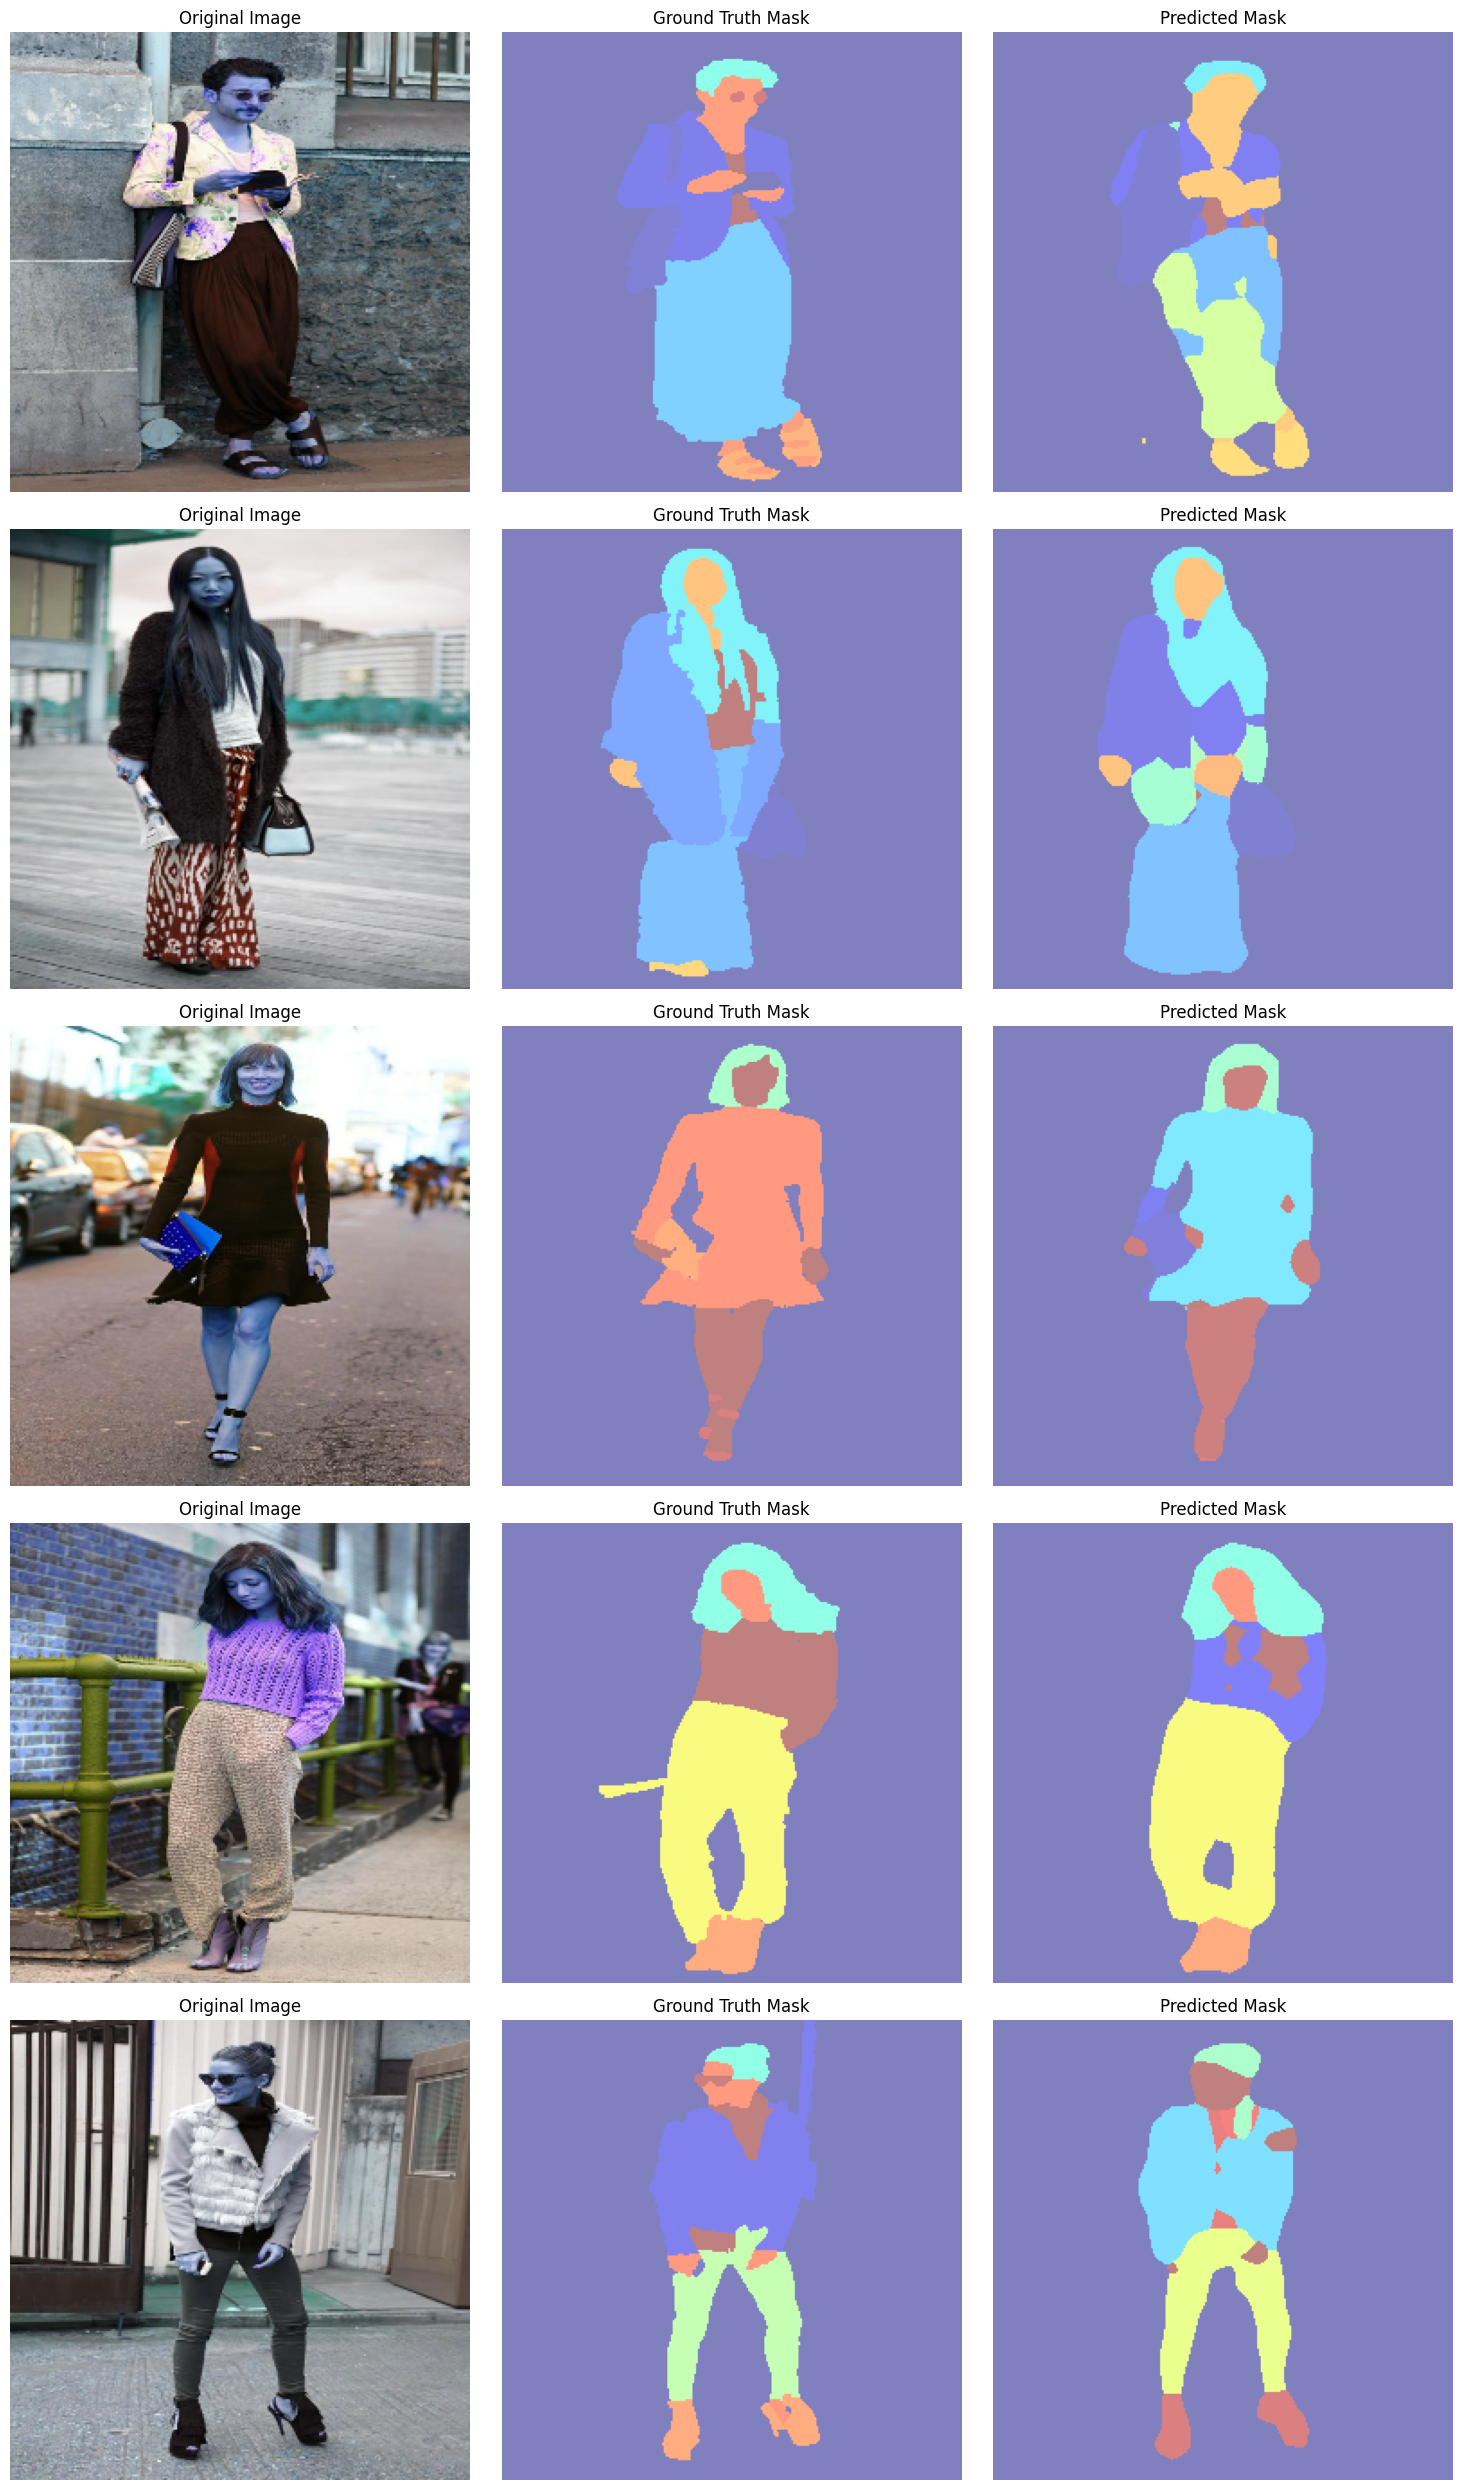

=== Model Evaluation Metrics (16 Batch Size) ===
Pixel Accuracy: 0.8867
Mean IoU: 0.1319
Average Inference Time per Image: 0.1287 seconds
Precision: 0.8791
Recall: 0.8867
F1 Score: 0.8798
=== Model Evaluation Metrics (1 Batch Size) ===
Average Inference Time per Image: 0.0146 seconds
Pixel Accuracy: 0.8867
Mean IoU: 0.1319
Precision: 0.8791
Recall: 0.8867
F1 Score: 0.8798


/var/folders/lt/yb6yj7rs5_566mgz0b3c9hd00000gn/T/ipykernel_15864/3049320132.py:65: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


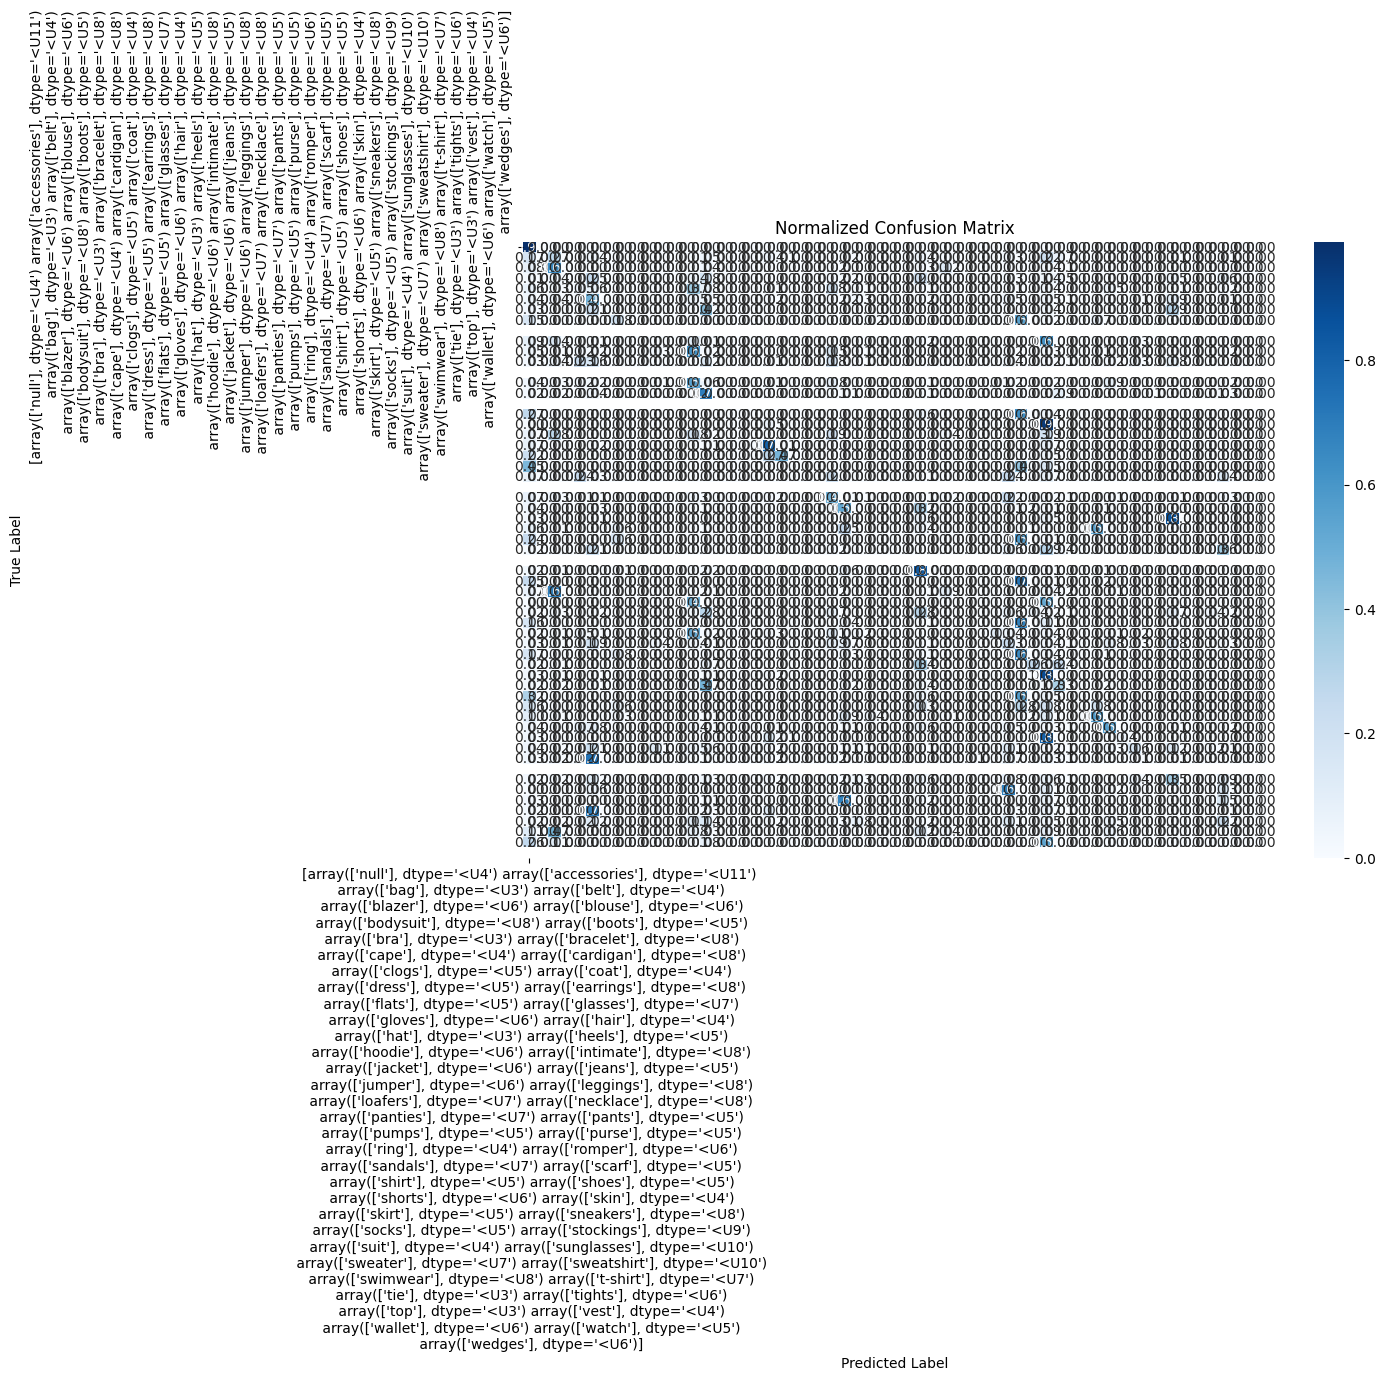

In [69]:
# Define directories for validation images and labels
val_image_dir = 'clothing-co-parsing/photos/'  # Same as training images if they are in the same directory
val_label_dir = 'clothing-co-parsing/annotations/pixel-level/'  # Same as training labels

# Create the validation dataset
val_dataset = ClothingDataset(val_images, val_image_dir, val_label_dir, transform=transform)

# Evaluation for pixel accuracy and mean IoU with larger batch size
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
num_classes = 59  # Set according to your dataset

# Visualization of predictions
visualize_predictions(model, val_dataloader, num_images=5)

# Evaluate and print accuracy and mean IoU
# Using a catch-all variable to handle any extra returned values
evaluation_results = evaluate_model(model, val_dataloader, num_classes)
# Extract the metrics from the results
accuracy = evaluation_results[0]              # Pixel accuracy
mean_iou = evaluation_results[1]               # Mean IoU
average_inference_time = evaluation_results[2]  # Average inference time
precision = evaluation_results[3]               # Precision
recall = evaluation_results[4]                  # Recall
f1 = evaluation_results[5]                      # F1 score
true_labels = evaluation_results[6]             # True labels
predicted_labels = evaluation_results[7]        # Predicted labels

# Print the results
print("=== Model Evaluation Metrics (16 Batch Size) ===")
print(f'Pixel Accuracy: {accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'Average Inference Time per Image: {average_inference_time:.4f} seconds')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Evaluation for average inference time with batch size of 1
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# After evaluating the model, retrieve new metrics
# Using a catch-all variable to handle any extra returned values
evaluation_results = evaluate_model(model, val_dataloader, num_classes)
# Extract the metrics from the results
accuracy = evaluation_results[0]              # Pixel accuracy
mean_iou = evaluation_results[1]               # Mean IoU
average_inference_time = evaluation_results[2]  # Average inference time
precision = evaluation_results[3]               # Precision
recall = evaluation_results[4]                  # Recall
f1 = evaluation_results[5]                      # F1 score
true_labels = evaluation_results[6]             # True labels
predicted_labels = evaluation_results[7]        # Predicted labels

print("=== Model Evaluation Metrics (1 Batch Size) ===")
print(f'Average Inference Time per Image: {average_inference_time:.4f} seconds')
print(f'Pixel Accuracy: {accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

### Thank You For Your Time!